This notebook loads in the trained model and visualises hidden layer representations using a chosen data file using t-SNE. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE

In [2]:
class BranchingAE(nn.Module):
    def __init__(self):
        super(BranchingAE, self).__init__()

        #Branch for velocities (first 3 features)
        self.velocity_branch = nn.Sequential(
            nn.Conv1d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2),

            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2)
        )

        #Branch for tortuosity (4th feature)
        self.tortuosity_branch = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2),

            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2)
        )

        #Branch for angular velocities (last 3 features (out of 7))
        self.ang_velocity_branch = nn.Sequential(
            nn.Conv1d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2),

            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2)
        )

        #Shared decoder for merging the features
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels = 192, out_channels = 128, kernel_size = 2, stride = 2),
            nn.ELU(),

            nn.ConvTranspose1d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2),
            nn.ELU(),

            nn.ConvTranspose1d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU()
        )

        #Output layers for different variables
        self.output_velocity = nn.Sequential(
            nn.Conv1d(in_channels = 32, out_channels = 3, kernel_size = 3, stride = 1, padding = 1),
            nn.Tanh()
        )

        self.output_tortuosity = nn.Sequential(
            nn.Conv1d(in_channels = 32, out_channels = 1, kernel_size = 3, stride = 1, padding = 1)
        )

        self.output_ang_velocity = nn.Sequential(
            nn.Conv1d(in_channels = 32, out_channels = 3, kernel_size = 3, stride = 1, padding = 1),
            nn.Tanh()
        )

    def forward(self, x):

        #print("Input shape:", x.shape)

        velocity = x[:, :, :3]
        tortuosity = x[:, :, 3:4]
        ang_velocity = x[:, :, 4:]

        #print("Velocity shape:", velocity.shape)
        #print("Tortuosity shape:", tortuosity.shape)
        #print("Angular velocity shape:", ang_velocity.shape)

        velocity = velocity.permute(0, 2, 1)
        tortuosity = tortuosity.permute(0, 2, 1)
        ang_velocity = ang_velocity.permute(0, 2, 1)

        #print("Permuted elocity shape:", velocity.shape)
        #print("permuted tortuosity shape:", tortuosity.shape)
        #print("Permuted angular velocity shape:", ang_velocity.shape)

        #Permutes to desired shape
        velocity_encoded = self.velocity_branch(velocity)
        tortuosity_encoded = self.tortuosity_branch(tortuosity)
        ang_velocity_encoded = self.ang_velocity_branch(ang_velocity)

        #print("Velocity encoded shape:", velocity_encoded.shape)
        #print("Tortuosity encoded shape:", tortuosity_encoded.shape)
        #print("Angular velocity encoded shape:", ang_velocity_encoded.shape)

        #Concatenates encoded features
        combined_encoded = torch.cat((velocity_encoded, tortuosity_encoded, ang_velocity_encoded), dim = 1)

        #print("Combined encoded shape:", combined_encoded.shape)

        #Decodes combined features
        decoded = self.decoder(combined_encoded)

        #print("Decoded shape:", decoded.shape)

        #Generates outputs for each set of variables
        velocity_output = self.output_velocity(decoded)
        tortuosity_output = self.output_tortuosity(decoded)
        ang_velocity_output = self.output_ang_velocity(decoded)

        #print("Velocity output shape:", velocity_output.shape)
        #print("Tortuosity output shape:", tortuosity_output.shape)
        #print("Angular velocity output shape:", ang_velocity_output.shape)  

        #Concatenates all outputs
        combined_output = torch.cat((velocity_output, tortuosity_output, ang_velocity_output), dim = 1)
        
        #print("Combined output shape:", combined_output.shape)

        #Permutes back
        output = combined_output.permute(0, 2, 1)
        
        #print("Final output shape:", output.shape)

        return output
    
    def encode(self, x):

        velocity = x[:, :, :3]
        tortuosity = x[:, :, 3:4]
        ang_velocity = x[:, :, 4:]

        velocity = velocity.permute(0, 2, 1)
        tortuosity = tortuosity.permute(0, 2, 1)
        ang_velocity = ang_velocity.permute(0, 2, 1)

        #Permutes to desired shape
        velocity_encoded = self.velocity_branch(velocity)
        tortuosity_encoded = self.tortuosity_branch(tortuosity)
        ang_velocity_encoded = self.ang_velocity_branch(ang_velocity)

        #Concatenates encoded features
        combined_encoded = torch.cat((velocity_encoded, tortuosity_encoded, ang_velocity_encoded), dim = 1)

        return combined_encoded



In [3]:
#Initialises the model
model = BranchingAE()

#Loads the pre-trained weights
model.load_state_dict(torch.load("/Users/maks/Documents/MSc_project/data/models/branching_ae_long_test.pth"))

#Sets the model to evaluation mode
model.eval()


BranchingAE(
  (velocity_branch): Sequential(
    (0): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ELU(alpha=1.0)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ELU(alpha=1.0)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tortuosity_branch): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ELU(alpha=1.0)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ELU(alpha=1.0)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ang_velocity_branch): Sequential(
    (0): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ELU(alpha=1.0)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [4]:
def generate_random_samples(batch, read = "/Users/maks/Documents/MSc_project/data/features", sequence_length = 60):
    """
    A function that creates a list of independent arrays that are to serve as samples for processing later.
    read is the directory where Excel files containing variables are stored;
    batch is the number of samples that will be generated;
    sequence length is the length of each sample.
    Returns a list of numpy arrays.
    """

    def load_excel(file_path):
        """
        Extracts sheets from Excel files given a file directory.
        """
        excel_file = pd.ExcelFile(file_path)
        
        sheets = {sheet_name: pd.read_excel(excel_file, sheet_name = sheet_name, engine = "openpyxl") for sheet_name in excel_file.sheet_names}

        return sheets
    
    def random_file(read):
        """
        Chooses a random file from a provided directory.
        """
        files = [f for f in os.listdir(read) if f.endswith(".xlsx") and not f.startswith(".")]
        
        if not files:
            raise FileNotFoundError("No Excel files found in the directory")
        
        choice = random.choice(files)
        print(f"The file used is: {choice}")
        
        return os.path.join(read, choice)
    
    def normalise_columns(df, columns):
        """
        Normalises specified columns between -1 and 1.
        """
        df = df.copy()  # Make a copy to avoid modifying the original DataFrame
    
        for column in columns:
            max_val = df[column].max()
            min_val = df[column].min()
            
            df.loc[:, column] = 2 * (df[column] - min_val) / (max_val - min_val) - 1

        return df

    def sampler(sheet_data, sequence_length):
        """
        Randomly creates a sample from an Excel sheet.
        sheet_data are sheets representing time series segments from where data is going to be sampled
        sequence_length is the number of points each sample will contain.
        """

        #Normalises velocities and angular velocities using normalise_columns
        columns = ["velocity_x", "velocity_y", "velocity_z", "angular_velocity_yz", "angular_velocity_xz", "angular_velocity_xy"]
        sheet_data = normalise_columns(sheet_data, columns)

        num_points = len(sheet_data)

        if num_points < sequence_length + 2:
            return None
        
        start_index = random.randint(2, num_points - sequence_length)
        end_index = start_index + sequence_length
        sample = sheet_data.iloc[start_index : end_index].to_numpy()

        return sample #Transposes the samle to switch rows and columns
    
    def weighted_random_choice(sheets):
        """
        Assigns weights to sheets based on the length of each sheet.
        """
        total_points = sum(len(data) for data in sheets.values())
        weights = [len(data) / total_points for data in sheets.values()]

        return random.choices(list(sheets.keys()), weights = weights, k = 1)[0]
    
    #Initializes list to strore sample arrays
    samples = []

    while len(samples) < batch:
        file_path = random_file(read)
        sheets = load_excel(file_path)

        while len(samples) < batch:
            sheet_name = weighted_random_choice(sheets)
            sheet_data = sheets[sheet_name][["velocity_x", "velocity_y", "velocity_z", "tortuosity3d", "angular_velocity_yz", "angular_velocity_xz", "angular_velocity_xy"]]
            sample = sampler(sheet_data, sequence_length)

            if sample is not None:
                samples.append(sample)

            #Stops once batch size is reached
            if len(samples) >= batch:
                break

    return samples

In [5]:
#Class to contain our sampled time series data
class TimeSeriesData(Dataset):
    def __init__(self, no_samples):
        self.data = generate_random_samples(no_samples)
        self.data = np.array(self.data)

        self.data = torch.tensor(self.data, dtype = torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]

In [94]:
no_samples = 8192
batch_size = 8192

dataset = TimeSeriesData(no_samples)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

The file used is: red61.xlsx


In [95]:
hidden_representations = []

for batch_data in dataloader:
    with torch.no_grad():  #No gradient calculation needed for inference
        hidden_repr = model.encode(batch_data)  #Obtains the hidden layer representation
        hidden_representations.append(hidden_repr.numpy())  

#Concatenates all batches to form a single array
hidden_representations = np.concatenate(hidden_representations, axis=0)

In [96]:
#Flat representations
batch_size, sequence_length, num_features = hidden_representations.shape
hidden_representations_flat = hidden_representations.reshape(batch_size, -1)
#Mean representations
hidden_representations_mean = hidden_representations.mean(axis=1) 

In [97]:
#Applies tSNE
flat_tsne = TSNE(n_components=2, random_state=42).fit_transform(hidden_representations_flat)
mean_tsne = TSNE(n_components=2, random_state=42).fit_transform(hidden_representations_mean)


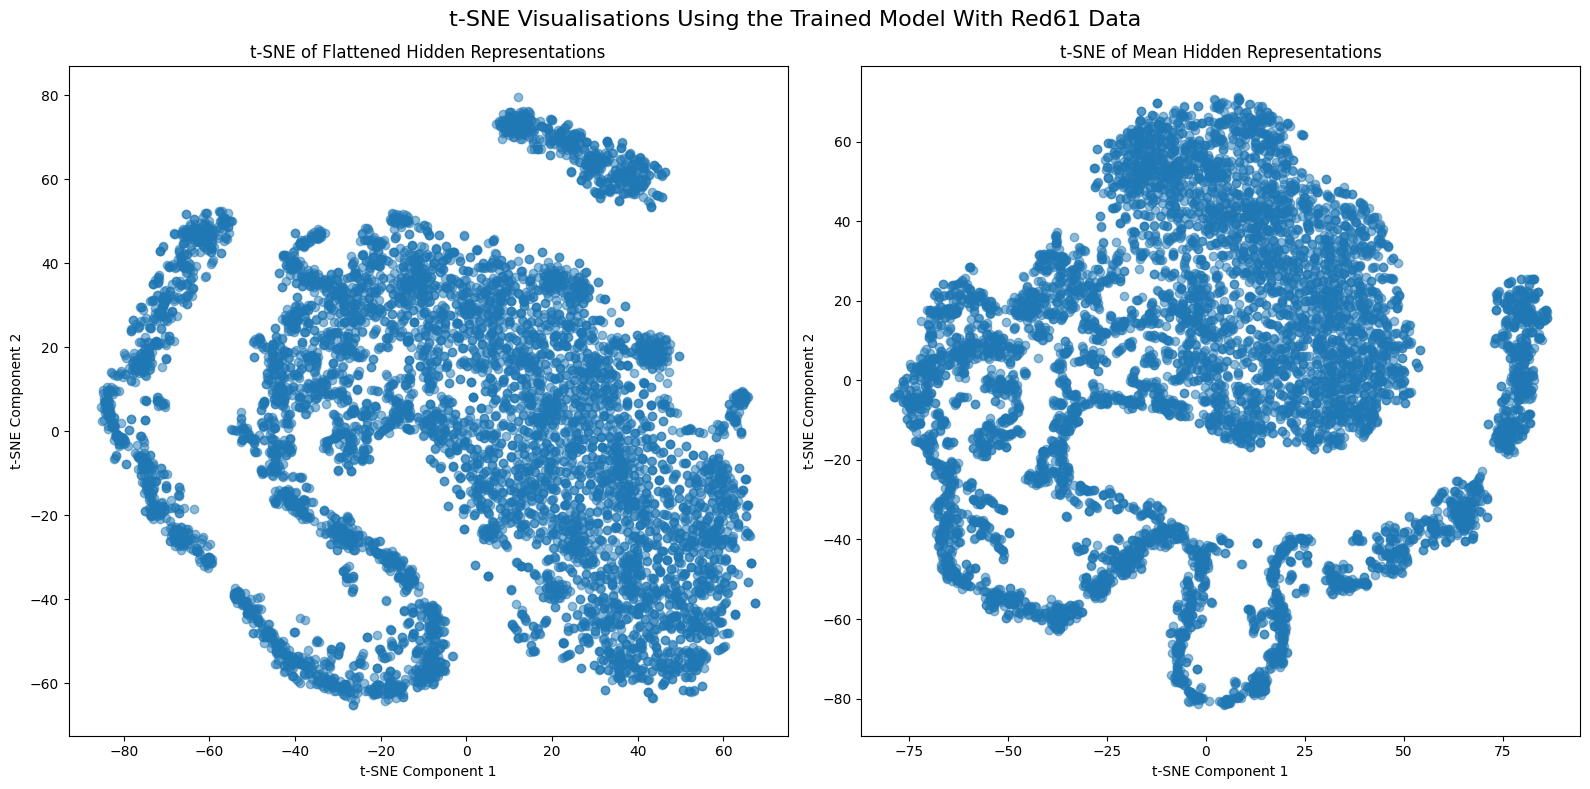

In [99]:
#Creates subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

#Plots t-SNE for flattened representations
ax[0].scatter(flat_tsne[:, 0], flat_tsne[:, 1], alpha=0.5)
ax[0].set_title("t-SNE of Flattened Hidden Representations")
ax[0].set_xlabel("t-SNE Component 1")
ax[0].set_ylabel("t-SNE Component 2")

#Plots t-SNE for mean representations
ax[1].scatter(mean_tsne[:, 0], mean_tsne[:, 1], alpha=0.5)
ax[1].set_title("t-SNE of Mean Hidden Representations")
ax[1].set_xlabel("t-SNE Component 1")
ax[1].set_ylabel("t-SNE Component 2")

#Adds a central title
plt.suptitle("t-SNE Visualisations Using the Trained Model With Red61 Data", fontsize=16)

#Shows the plot
plt.tight_layout()
plt.show()